In [1]:

#x range: +- 200
#z range: 500, 2000
#vx range: +- 10
#vz range: -30, 10

#m range: 8000, 12000
import pandas as pd
import numpy as np
import scipy as sp
from scipy import integrate as spint
import matplotlib.pyplot as plt

from math import sin, cos, asin

from rocket import Rocket

In [2]:
r = Rocket(*[-30., 1000., 10., 20., 10000.])

In [3]:
r

In [4]:
r.s_0

(-30.0, 1000.0, 10.0, 20.0, 10000.0)

In [5]:
r.propagate(r.s_0, (0,0))

(-29.0, 1002.0, 10.0, 19.83771, 10000.0)

In [30]:

t = 0.
s = r.s_0
dt = 0.1
history = [(t, *s)]

while t < r.t_char:
    t = t+dt
    s = r.propagate(s, (0.,0.), dt)
    history.append((t, *s))

In [37]:
t

49.600000000000435

In [32]:
df = pd.DataFrame.from_records(history, columns=['t','x','z','vx','vz','m'])

In [33]:
df.head()

,t,x,z,vx,vz,m
0,0.0,-30.0,1000.000000,10.0,20.00000,10000.0
1,0.1,-29.0,1002.000000,10.0,19.83771,10000.0
2,0.2,-28.0,1003.983771,10.0,19.67542,10000.0
3,0.3,-27.0,1005.951313,10.0,19.51313,10000.0
4,0.4,-26.0,1007.902626,10.0,19.35084,10000.0


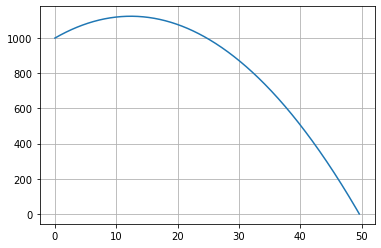

In [34]:
plt.plot(df.t, df.z)
plt.grid()

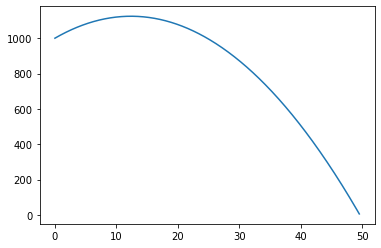

In [35]:
plt.plot(df.t[df.z>0], df.z[df.z>0])

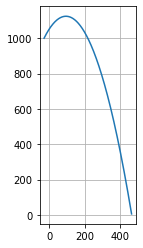

In [36]:
plt.plot(df.x[df.z>0], df.z[df.z>0])
ax = plt.gca()
ax.set_aspect(1)
plt.grid()

Text(0, 0.5, 'z (m)')

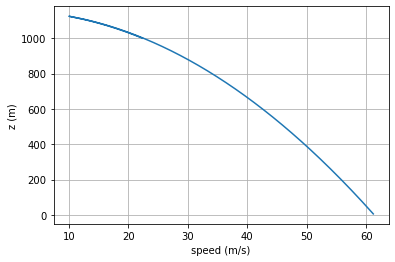

In [13]:
plt.plot(((df.vx**2+df.vz**2)**0.5)[df.z>0], df.z[df.z>0])
plt.grid()
plt.xlabel("speed (m/s)")
plt.ylabel("z (m)")

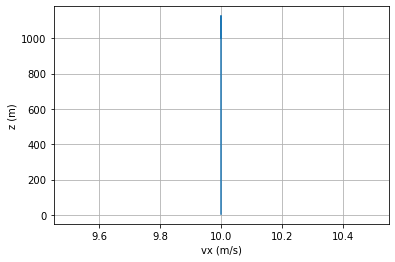

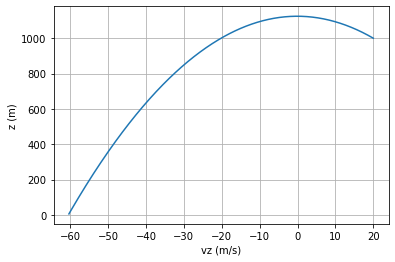

In [14]:
plt.plot(df.vx[df.z>0], df.z[df.z>0])
plt.grid()
plt.xlabel("vx (m/s)")
plt.ylabel("z (m)")
plt.show()

plt.plot(df.vz[df.z>0], df.z[df.z>0])
plt.grid()
plt.xlabel("vz (m/s)")
plt.ylabel("z (m)")
plt.show()

In [15]:
#attempt to solve the mass optimal control problem
def bvp_dynamics(t, s, p):
    #t (time) #not needed
    #s (state) #(x,z,vx,vz,m,lambdam)
    #p (parameters) #(lx0, lz0, lvx0, lvz0)
    
    #implicitly assumes alpha = 1
    
    
    (x, z, vx, vz, m, lm)  = s
    (lx0, lz0, lvx0, lvz0) = p
    
    lv_mag = (lvx0**2+lvz0**2)**0.5
    
    
    #determine u1
    S1 = 1 - (lv_mag*r.c2)/m - lm
    if len(S1) == 1:
        u1 = (lambda s: 1 if s<0 else 0)(S1)
    else:
        u1 = np.array([(lambda s: 1 if s<0 else 0)(s1) for s1 in S1])
        
    #determine u2, ith
    ith1 = -(1/lv_mag)*(lvx0)
    ith2 = -(1/lv_mag)*(lvz0)
    
    #construct dynamics
    ds = [None]*6
    
    ds[0] = vx
    ds[1] = vz
    
    ds[2] = (u1*(ith1/m))*r.c1
    ds[3] = (u1*(ith2/m))*r.c1 - r.g
    
    ds[4] = u1*(-r.c1/r.c2)
    
    
    ds[5] = ((u1/m**2)*r.c1)*((lvx0-lx0*t)*ith1 + (lvz0-lz0*t)*ith2)
    
    return ds
    
def bvp_boundary(sa, sb, p):
    
    res = []
    
    #initial conditions:
    res.append(sa[0] - r.x_0 )
    res.append(sa[1] - r.z_0 )
    res.append(sa[2] - r.vx_0)
    res.append(sa[3] - r.vz_0)
    res.append(sa[4] - r.m_0 )
    
    #final conditions
    res.append(sb[0] - 0)
    res.append(sb[1] - 0)
    res.append(sb[2] - 0)
    res.append(sb[3] - 0)
    res.append(sb[5] - 0) #lambda m = 0 in final time
    
    return np.array(res)
    

In [16]:
np.diff(x_g)/(t_guess[1]-t_guess[0])

NameError: name 'x_g' is not defined

In [ ]:
t_guess = np.linspace(0, (2*r.z_0/r.g)/2)

x_g  = np.linspace(r.x_0,  0)
z_g  = np.linspace(r.z_0,  0)
vx_g = np.linspace(r.vx_0, 0)
vz_g = np.linspace(r.vz_0, 0)
m_g  = np.linspace(r.m_0,  0.7*r.m_0)
lm_g = np.linspace(10,1)



state_guess = np.array([x_g, z_g, vx_g, vz_g, m_g, lm_g])

In [ ]:
r.vx_0

In [ ]:
state_guess.shape

In [ ]:
p_guess = np.array([-10,-10,10,10])

In [ ]:
bvp_dynamics(0, state_guess, p_guess)

In [ ]:
bvp_boundary(r.s_0, [0,0,0,0,7500,0], [1,1,1,1])

In [ ]:
sol = spint.solve_bvp(bvp_dynamics, bvp_boundary, x = t_guess, y = state_guess, p=p_guess, verbose=2)

In [ ]:
sol

In [ ]:
t_sol = sol.x

In [ ]:
(x_sol, z_sol, vx_sol, vz_sol, m_sol, lm_sol) =  sol.y

In [ ]:
plt.plot(t_sol, vz_sol)
plt.grid()

In [ ]:
plt.plot(t_guess, m_g)
plt.grid()

In [ ]:
vz_sol-vz_g